In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import glob
import copy

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from skimage.transform import resize

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Model

In [3]:
class SRCNN(nn.Module):
    def __init__(self, grayscale=True):
        if grayscale:
            channels = 1
        else:
            channels = 3
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=channels, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Utils

In [4]:
def model_predict(model, lr_img):
    lr_img_tensor = lr_img.clone().detach().unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        model.eval()
        hr_tensor = model(lr_img_tensor.squeeze(0).to(device))

    hr_img = hr_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    return hr_img

def compute_psnr_image(im1, im2):
    imdff = im1.astype(np.float64) - im2.astype(np.float64)
    imdff = imdff.flatten()

    rmse = np.sqrt(np.mean(imdff ** 2))

    if rmse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(255 / rmse)

    return psnr

def get_avg_psnr(model, images_path, upscale_factor, grayscale=True):
    cnt = 0
    avg_srcnn_psnr = 0
    avg_bicubic_psnr = 0
    for filename in os.listdir(images_path):
        file_path = os.path.join(images_path, filename)
        
        if filename.endswith('.bmp'):
            cnt+=1
            if grayscale:
                gt_img = Image.open(file_path).convert('L')
            else:
                gt_img = Image.open(file_path).convert('RGB')
            gt_img, lr_img = prepImage(gt_img, upscale_factor)
            up_img = model_predict(model, lr_img)

            lr_img = lr_img.numpy()

            gt_pil = tensor_to_image(gt_img)
            lr_pil = tensor_to_image(lr_img)
            up_pil = tensor_to_image(up_img)

            avg_srcnn_psnr += compute_psnr_image(np.array(gt_pil), np.array(up_pil))
            avg_bicubic_psnr += compute_psnr_image(np.array(gt_pil), np.array(lr_pil))

    return avg_bicubic_psnr/cnt, avg_srcnn_psnr/cnt

def tensor_to_image(tensor):
    if np.ndim(tensor) == 3:
        image_array = np.transpose(tensor, (1, 2, 0)) * 255
    else:
        image_array = tensor * 255

    if image_array.dtype != np.uint8:
        image_array = np.clip(image_array, 0, 255).astype(np.uint8)
    
    return Image.fromarray(image_array.squeeze())

def prepImage(gt_img, upscale_factor=3):
    gt_data = np.array(gt_img)

    # gt_data = np.expand_dims(gt_data, axis=0)
    # gt_data = np.expand_dims(gt_data, axis=0)

    lr_data = resize(gt_data, (gt_data.shape[0] // upscale_factor, gt_data.shape[1] // upscale_factor), order=3)
    lr_data = resize(lr_data, gt_data.shape, order=3)

    transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    gt_data = transform(gt_data).squeeze(0)
    lr_data = transform(lr_data).squeeze(0)

    return gt_data.numpy(), lr_data.float()

def show_three_images(images, labels, figsize=(12, 4)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    for i in range(3):
        if (np.ndim(images[i]) == 3):
            images[i] = np.transpose(images[i], (1, 2, 0))

        if (np.ndim(images[i]) == 2):
            axes[i].imshow(np.clip(images[i], 0, 1), cmap="gray")
        else:
            axes[i].imshow(np.clip(images[i], 0, 1))
        axes[i].set_title(labels[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Dataset

In [5]:
class ImageDataset(Dataset):
    img_segments_lr = []
    img_segments_hr = []

    def __init__(self, folder_path, upscale_factor=3, divide = True, grayscale=True, segment_size=(33, 33), stride=14):
        self.image_paths = glob.glob(os.path.join(folder_path, '*.bmp'))
        self.upscale_factor = upscale_factor
        self.segment_size = segment_size
        self.stride = stride

        self.img_segments_lr = []
        self.img_segments_hr = []
        
        for path in self.image_paths:
            if grayscale:
                img = Image.open(path).convert('L')
            else:
                img = Image.open(path).convert('RGB')

            img, lr_img = prepImage(img, upscale_factor)
            
            img_height, img_width = img.shape[1], img.shape[2]

            if not divide:
                self.img_segments_lr.append(lr_img)
                self.img_segments_hr.append(img)
            else:
                for x in range(0, img_height - self.segment_size[0] + 1, self.stride):
                    for y in range(0, img_width - self.segment_size[1] + 1, self.stride):
                        lr_segment = lr_img[:, x:x+self.segment_size[0], y:y+self.segment_size[1]]
                        hr_segment = img[:, x:x+self.segment_size[0], y:y+self.segment_size[1]]
                        
                        self.img_segments_lr.append(lr_segment)
                        self.img_segments_hr.append(hr_segment)

    def __len__(self):
        return len(self.img_segments_lr)

    def __getitem__(self, idx):
        return self.img_segments_lr[idx], self.img_segments_hr[idx]

# Train

In [6]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=50, device='cpu'):
    model.train()
    tqdmEpoch = 1
    
    best_psnr = -float('inf')
    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = -1

    with tqdm(total=len(train_dataloader) * num_epochs, desc=f'Epoch {tqdmEpoch}/{num_epochs}', unit=' patches') as pbar:
        for epoch in range(num_epochs):
            # train
            epoch_loss = 0
            for lr_image, hr_image in train_dataloader:
                optimizer.zero_grad()
                outputs = model(lr_image.to(device))
                loss = criterion(outputs.squeeze(0), hr_image.squeeze(0).to(device))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                pbar.update(1)
            
            avg_loss = epoch_loss / len(train_dataloader)
            tqdmEpoch += 1
            pbar.set_description_str(f'Epoch {tqdmEpoch}/{num_epochs}', refresh=True)
            pbar.set_postfix(loss=avg_loss)

            # evaluate
            model.eval()
            psnr_sum = 0
            with torch.no_grad():
                for lr_image, hr_image in test_dataloader:
                    outputs = model(lr_image.to(device))
                    psnr = compute_psnr_image(
                        np.array(tensor_to_image(outputs.squeeze(0).cpu().numpy())), 
                        np.array(tensor_to_image(hr_image.squeeze(0).numpy())))
                    psnr_sum += psnr
            
            avg_psnr = psnr_sum / len(test_dataloader)

            if avg_psnr > best_psnr:
                best_psnr = avg_psnr
                best_epoch = tqdmEpoch-1
                best_weights = copy.deepcopy(model.state_dict())

            model.train()

        pbar.set_description_str(f'Epoch {tqdmEpoch-1}/{num_epochs}', refresh=True)

    torch.save(best_weights, 'TrainedModels/best.pt')
    print(f"Best model saved. Epoch - {best_epoch}")
    torch.save(model.state_dict(), 'TrainedModels/last.pt')
    print(f"Last model saved. Epoch - {num_epochs}")

# Showcase

### Settings

In [7]:
batch_size = 4
learning_rate = 1e-4
num_epochs = 100 # 22092/epoch
upscale_factor = 3
grayscale = False

mode = "load"
# mode =  "train"
# mode = "load-train"

# load_model_name = "old_rgb_300_bs16.pt"
load_model_name = "best_192_bs4.pt"
# load_model_name = "best_89_bs16.pt"
# load_model_name = "last_200_bs4.pt"
# load_model_name = "last.pt"
# load_model_name = "best.pt"


### Dataloader

In [8]:
train_dataset = ImageDataset('./Train', upscale_factor, grayscale=grayscale)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageDataset('./Test/Set14', upscale_factor, divide=False, grayscale=grayscale)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

print(len(train_dataset))

22092


### Train

In [9]:
model = SRCNN(grayscale=grayscale).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': model.conv1.parameters(), 'lr': learning_rate},
    {'params': model.conv2.parameters(), 'lr': learning_rate},
    {'params': model.conv3.parameters(), 'lr': learning_rate * 0.1}
])

if mode == "train":
    train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device)
elif mode == "load-train":
    model.load_state_dict(torch.load('TrainedModels/' + load_model_name, weights_only=False))
    print("Loaded model: " + load_model_name)
    train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device)
else:
    model.load_state_dict(torch.load('TrainedModels/' + load_model_name, weights_only=False))
    print("Loaded model: " + load_model_name)
    print(model)

Loaded model: best_192_bs4.pt
SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


### Use

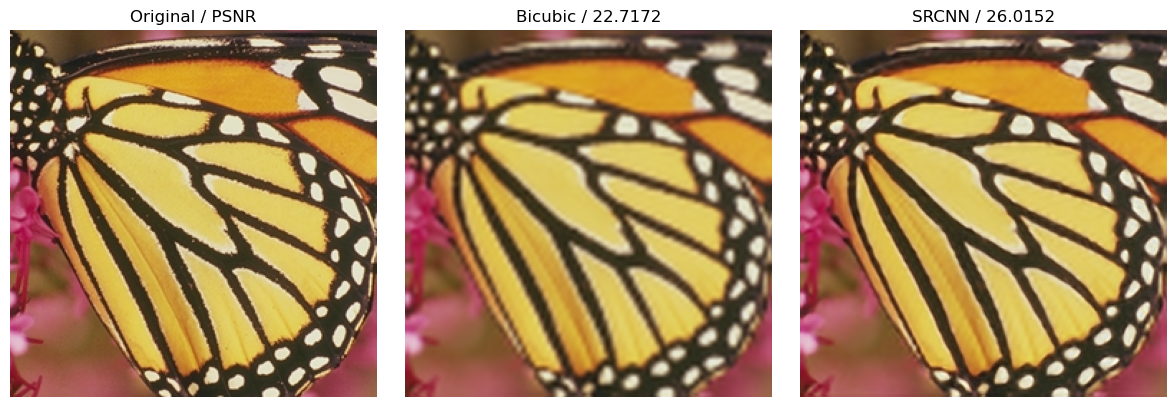

In [10]:
path = "./Test/Set5/butterfly_GT.bmp"
# path = "./Test/Set14/zebra.bmp"
# path = "./Test/Set14/lenna.bmp"
# path = "./Test/Set14/ppt3.bmp"
# path = "./Test/test.bmp"

model.load_state_dict(torch.load('TrainedModels/' + load_model_name, weights_only=False))

if grayscale:
    gt_img = Image.open(path).convert('L')
else:
    gt_img = Image.open(path).convert('RGB')
gt_img, lr_img = prepImage(gt_img, upscale_factor)
up_img = model_predict(model, lr_img)

lr_img = lr_img.numpy()

gt_pil = tensor_to_image(gt_img)
lr_pil = tensor_to_image(lr_img)
up_pil = tensor_to_image(up_img)

# lr_pil.show()
# up_pil.show()
# gt_pil.show()

srcnn_psnr = compute_psnr_image(np.array(gt_pil), np.array(up_pil))
bicubic_psnr = compute_psnr_image(np.array(gt_pil), np.array(lr_pil))

show_three_images([gt_img, lr_img, up_img], ["Original / PSNR", f"Bicubic / {round(bicubic_psnr, 4)}", f"SRCNN / {round(srcnn_psnr, 4)}"])

In [11]:
set5 = "./Test/Set5/"
set14 = "./Test/Set14/"

print("Model:", load_model_name)
bic, srcnn = get_avg_psnr(model, set5, upscale_factor=upscale_factor, grayscale=grayscale)
print("Set5\n", f"Bicubic / {round(bic, 4)}\n", f"SRCNN / {round(srcnn, 4)}")
bic, srcnn = get_avg_psnr(model, set14, upscale_factor=upscale_factor, grayscale=grayscale)
print("Set14\n", f"Bicubic / {round(bic, 4)}\n", f"SRCNN / {round(srcnn, 4)}")

Model: best_192_bs4.pt
Set5
 Bicubic / 28.586
 SRCNN / 30.3921
Set14
 Bicubic / 25.6353
 SRCNN / 26.7693
